# Autonomous Underwater Vehicle Fault Diagnosis

Ji, Daxiong (2021), “Autonomous Underwater Vehicle Fault Diagnosis Dataset”, Mendeley Data, V1, doi: 10.17632/7rp2pmr6mx.1

Dataset source: https://data.mendeley.com/datasets/7rp2pmr6mx/1

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.datatypes import convert_to
from sktime.datatypes._panel._convert import (
    from_3d_numpy_to_nested,
    from_3d_numpy_to_multi_index,
    from_multi_index_to_nested
)

%matplotlib inline

## Data processing

In [47]:
def get_label(file_path):
    return file_path.replace("\\", "/").split("/")[-2]

def reorder_columns(columns):
    cols = list(columns)
    return cols[-2:] + cols[:-2]

def get_data(dataset_path):
    df = pd.DataFrame()
    labels = []
    instance_id = 0
    DF_LENGTH = 180

    for file_path in glob.glob(dataset_path, recursive=True):
        df_tmp = pd.read_csv(file_path)

        if len(df_tmp) < DF_LENGTH:
            continue

        df_tmp = df_tmp[0:DF_LENGTH]
        df_tmp["instances"] = instance_id
        df_tmp["timepoints"] = list(range(0, DF_LENGTH))

        cols = reorder_columns(df_tmp.columns)
        df_tmp = df_tmp[cols]

        df = pd.concat([df, df_tmp])
        df = df.reset_index(drop=True)
        labels.append(get_label(file_path))
        instance_id += 1

    df = df.drop(["time"], axis=1)
    df = df.set_index(["instances", "timepoints"])

    return df, labels

In [50]:
%%time
# dataset_path = '/mnt/f/Downloads/Autonomous-Underwater-Vehicle-Fault-Diagnosis-Dataset/Dataset/train/**/*.csv'
# dataset_path = "../Downloads/autonomous-uboot/train/**/*.csv"

df_train, labels_train = get_data("../Downloads/autonomous-uboot/train/**/*.csv")

CPU times: total: 20.3 s
Wall time: 20.5 s


In [51]:
%%time

df_test, labels_test = get_data("../Downloads/autonomous-uboot/test/**/*.csv")

CPU times: total: 1.67 s
Wall time: 1.69 s


In [52]:
# preprocessed_path = "/mnt/f/Downloads/Autonomous-Underwater-Vehicle-Fault-Diagnosis-Dataset/Dataset/preprocessed/"
preprocessed_path = "../Downloads/autonomous-uboot/preprocessed/"
df_train.to_parquet(preprocessed_path + "features-train.parquet", index=True)
df_test.to_parquet(preprocessed_path + "features-test.parquet", index=True)

In [53]:
pd.DataFrame(labels_train, columns=["label"]).to_csv(preprocessed_path + "labels-train.csv", index=False)
pd.DataFrame(labels_test, columns=["label"]).to_csv(preprocessed_path + "labels-test.csv", index=False)

## Simple Exploratory Data Analysis (EDA)

In [ ]:
!ls -lh /mnt/f/Downloads/Autonomous-Underwater-Vehicle-Fault-Diagnosis-Dataset/Dataset/preprocessed/

In [ ]:
data_path = "/mnt/f/Downloads/Autonomous-Underwater-Vehicle-Fault-Diagnosis-Dataset/Dataset/preprocessed/"
df_train = pd.read_csv(data_path + "features-train.csv")
df_train = df_train.set_index(["instances", "timepoints"])
df_train.head()

In [ ]:
labels_train = pd.read_csv(data_path + "labels-train.csv")
labels_train['label'].unique()

In [ ]:
def tsplot(x, y, ax=None, n=20, percentile_min=1, percentile_max=99, color='r', plot_mean=True, plot_median=False, line_color='k', **kwargs):
    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.percentile(y, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
    perc2 = np.percentile(y, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)

    if 'alpha' in kwargs:
        alpha = kwargs.pop('alpha')
    else:
        alpha = 1/n
    # fill lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        ax.fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None)


    if plot_mean:
        ax.plot(x, np.mean(y, axis=0), color=line_color, label="mean")


    if plot_median:
        ax.plot(x, np.median(y, axis=0), color=line_color, label="median")
    
    return ax

In [ ]:
%%time

label_col = "label"
instance_col = "instances"
timepoints = list(range(180))
selected_cols = df_train.columns.difference(['time', 'pwm1', 'pwm2', 'pwm3', 'pwm4', 'depth', 'press'])

for feature_col in selected_cols:
    fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(15, 3))
    axs = axs.flatten()
    plot_id = 0

    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(f"Channel = '{feature_col}' ", fontsize=18, y=0.95)

    axs[plot_id].set_xlabel("Timepoints")
    axs[plot_id].set_ylabel(feature_col)

    for label in labels_train[label_col].unique():
        selected_idx = labels_train.index[labels_train[label_col] == label].tolist()
        stacked = None
        for idx in selected_idx:
            if stacked is None:
                stacked = df_train.loc[idx][feature_col].values
            else:
                stacked = np.vstack((stacked, df_train.loc[idx][feature_col].values))

        tsplot(timepoints, stacked, ax=axs[plot_id], n=1, percentile_min=25, percentile_max=75, 
               plot_median=True, plot_mean=False, color='#cce3de', line_color='#014f86')
        
        axs[plot_id].legend(loc="upper right")
        axs[plot_id].set_title(f"{label}")
        plot_id += 1
    
    plt.tight_layout()
    plt.show()

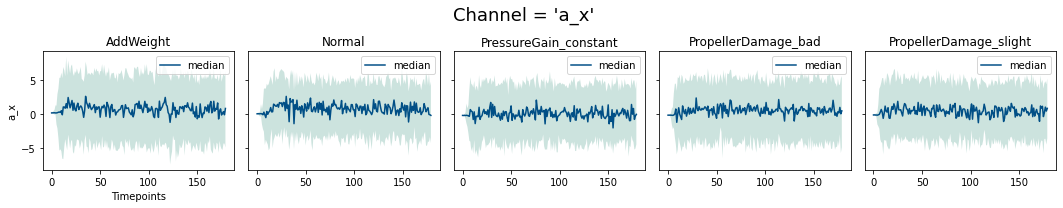

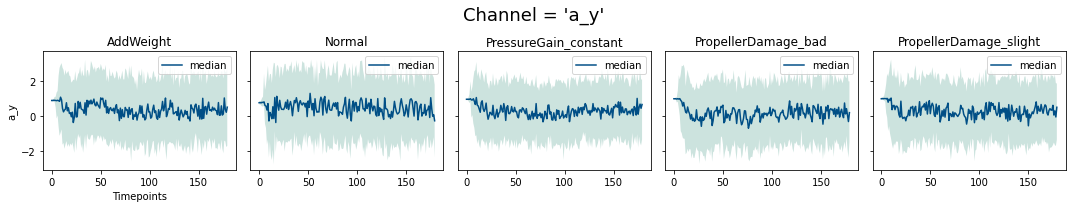

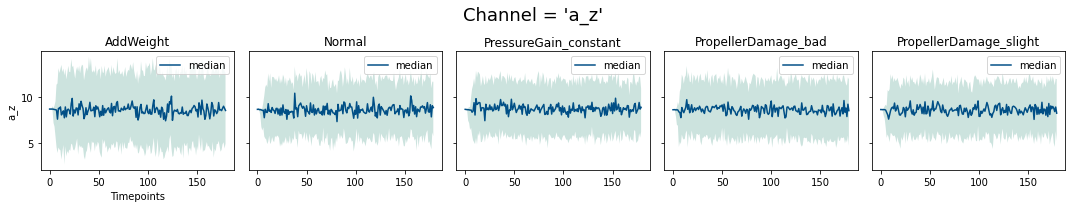

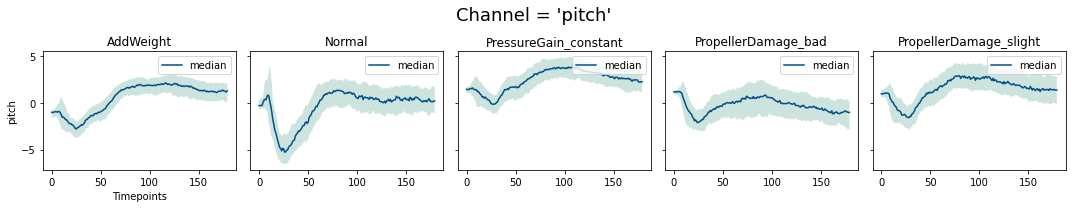

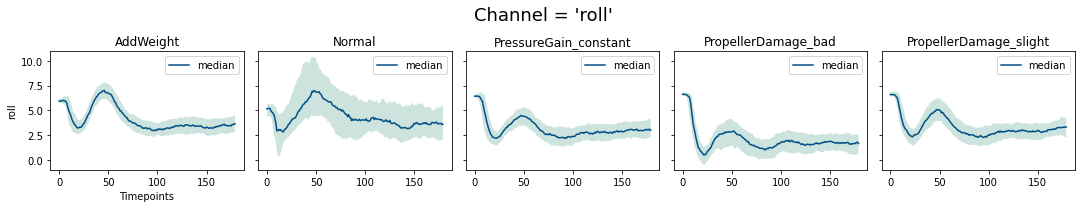

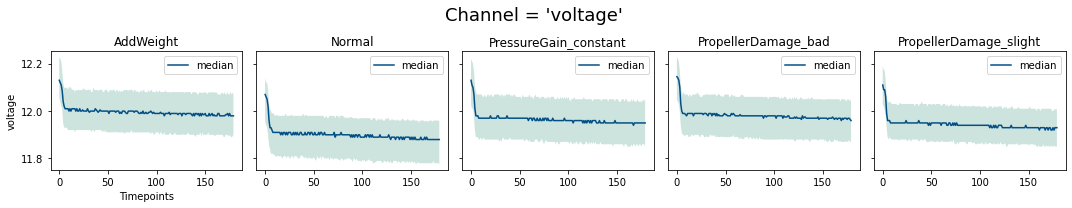

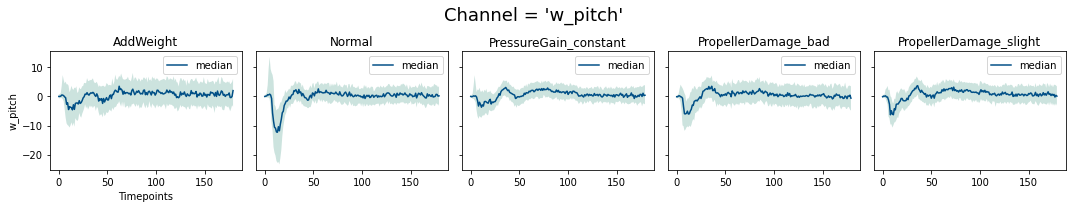

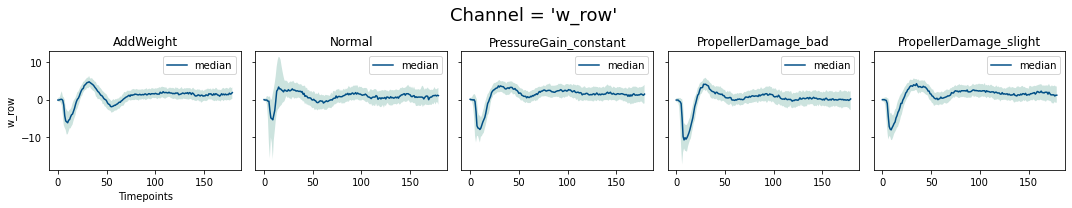

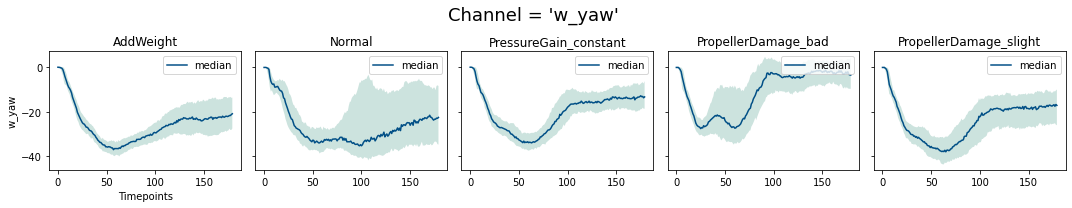

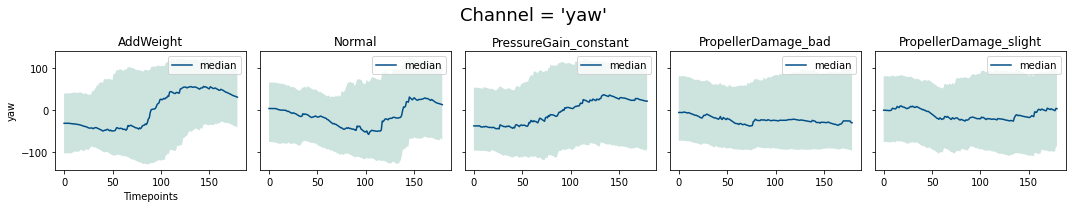

CPU times: user 19.6 s, sys: 1.87 s, total: 21.4 s
Wall time: 17.5 s


In [22]:
%%time

label_col = "label"
instance_col = "instances"
timepoints = list(range(180))
selected_cols = df_train.columns.difference(['time', 'pwm1', 'pwm2', 'pwm3', 'pwm4', 'depth', 'press'])

for feature_col in selected_cols:
    fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(15, 3))
    axs = axs.flatten()
    plot_id = 0

    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(f"Channel = '{feature_col}' ", fontsize=18, y=0.95)

    axs[plot_id].set_xlabel("Timepoints")
    axs[plot_id].set_ylabel(feature_col)

    for label in labels_train[label_col].unique():
        selected_idx = labels_train.index[labels_train[label_col] == label].tolist()
        stacked = None
        for idx in selected_idx:
            if stacked is None:
                stacked = df_train.loc[idx][feature_col].values
            else:
                stacked = np.vstack((stacked, df_train.loc[idx][feature_col].values))

        tsplot(timepoints, stacked, ax=axs[plot_id], n=1, percentile_min=25, percentile_max=75, 
               plot_median=True, plot_mean=False, color='#cce3de', line_color='#014f86')
        
        axs[plot_id].legend(loc="upper right")
        axs[plot_id].set_title(f"{label}")
        plot_id += 1
    
    plt.tight_layout()
    plt.show()